0.特徴量データ出力

In [40]:
# === 0) IBM_all_data.csv -> IBM_features.csv ==================================
import os
import numpy as np
import pandas as pd

RAW_CSV  = "IBM_all_data.csv"
FEAT_CSV = "IBM_features.csv"

# 任意の外生CSV（存在すれば自動で取り込む）：Date, Close（または Adj Close）があればOK
MARKET_CSV = None   # 例: "SPY.csv"
VIX_CSV    = None   # 例: "VIX.csv"
TNX_CSV    = None   # 例: "TNX.csv"

def ensure_datetime_naive(s: pd.Series) -> pd.Series:
    d = pd.to_datetime(s, errors="coerce", utc=True)
    return d.dt.tz_localize(None).dt.normalize()

def parse_split_value(x):
    if pd.isna(x) or x == 0:
        return 1.0
    if isinstance(x, (float, int)):
        return float(x) if x != 0 else 1.0
    if isinstance(x, str):
        x = x.strip()
        if x == "" or x == "0":
            return 1.0
        if ":" in x:
            a, b = x.split(":")
            try:
                a = float(a); b = float(b)
                if b != 0:
                    return a / b
            except:
                return 1.0
        try:
            v = float(x)
            return v if v != 0 else 1.0
        except:
            return 1.0
    return 1.0

# ---- 読み込み・日付正規化 ----------------------------------------------------
df = pd.read_csv(RAW_CSV)
assert "Date" in df.columns, "Date 列が必要です"
df["Date"] = ensure_datetime_naive(df["Date"])
df = df.sort_values("Date").dropna(subset=["Date"]).reset_index(drop=True)

# ---- スプリット補正（Stock Splits / Split）-----------------------------------
split_cols = [c for c in ["Split", "Stock Splits"] if c in df.columns]
split_today = pd.Series(1.0, index=df.index, dtype=float)
for c in split_cols:
    split_today = split_today * [parse_split_value(v) for v in df[c].values]

# 後ろから累積（将来基準の調整倍率）
split_cum = pd.Series(split_today.values[::-1]).cumprod()[::-1].values

def adj_col(s, factor):
    s = pd.to_numeric(s, errors="coerce")
    return s / factor

for col in ["Open", "High", "Low", "Close"]:
    if col in df.columns:
        df[col + "_adj"] = adj_col(df[col], split_cum)

# ---- 価格系基本 --------------------------------------------------------------
eps = 1e-12
C = pd.to_numeric(df.get("Close_adj", df["Close"]), errors="coerce")
O = pd.to_numeric(df.get("Open_adj",  df.get("Open", np.nan)),  errors="coerce")
H = pd.to_numeric(df.get("High_adj",  df.get("High", np.nan)),  errors="coerce")
L = pd.to_numeric(df.get("Low_adj",   df.get("Low",  np.nan)),  errors="coerce")
V = pd.to_numeric(df.get("Volume", 0), errors="coerce").fillna(0.0)

logC = np.log(C.clip(eps)); logO = np.log(O.clip(eps))
r1   = logC.diff(1)

def garman_klass(o,h,l,c):    return 0.5*(np.log(h/l)**2) - (2*np.log(2)-1)*(np.log(c/o)**2)
def parkinson(h,l):           return (np.log(h/l)**2) / (4*np.log(2))
def rogers_satchell(o,h,l,c): return np.log(h/c)*np.log(h/o) + np.log(l/c)*np.log(l/o)
def yang_zhang(prev_c,o,h,l,c,n=20):
    k = 0.34/(1.34 + (n+1)/(n-1)) if n>1 else 0.34/2.34
    overnight = (np.log(o/prev_c))**2
    rs = rogers_satchell(o,h,l,c)
    oc = (np.log(c/o))**2
    return overnight + k*oc + (1-k)*rs

feat = pd.DataFrame({"Date": df["Date"], "Close": C})
feat["ret_1"] = r1

# 高値安値レンジ/日中比/CLV
range_hl = np.log((H/L).clip(eps))
abs_co   = np.abs(np.log((C/O).clip(eps)))
clv      = (C - L) / (H - L).replace(0, np.nan)
feat["range_hl"] = range_hl
feat["abs_co"]   = abs_co
feat["clv"]      = clv

# ---- ローリング統計 ----------------------------------------------------------
for W in [5, 22, 66]:
    feat[f"GK_{W}"]  = garman_klass(O,H,L,C).rolling(W).mean()
    feat[f"PK_{W}"]  = parkinson(H,L).rolling(W).mean()
    feat[f"RS_{W}"]  = rogers_satchell(O,H,L,C).rolling(W).mean()
    feat[f"RV_{W}"]  = (r1**2).rolling(W).sum()
    feat[f"vol_{W}"] = r1.rolling(W).std()
    ma = C.rolling(W).mean()
    feat[f"SMA_{W}"] = ma
    feat[f"ZC_{W}"]  = (C - ma) / (C.rolling(W).std() + eps)

prevC = C.shift(1)
for W in [5, 22]:
    yz = yang_zhang(prevC, O,H,L,C, n=W)
    feat[f"YZ_{W}"] = yz.rolling(W).mean()

# ---- RSI / MACD / BB ---------------------------------------------------------
chg = C.diff()
gain = chg.clip(lower=0).rolling(14).mean()
loss = -chg.clip(upper=0).rolling(14).mean()
rs = gain / (loss + eps)
feat["RSI_14"] = 100 - 100/(1 + rs)

ema12 = C.ewm(span=12, adjust=False).mean()
ema26 = C.ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
signal = macd.ewm(span=9, adjust=False).mean()
feat["MACD"]     = macd
feat["MACDsig"]  = signal
feat["MACDhist"] = macd - signal

mb = C.rolling(20).mean()
sd = C.rolling(20).std()
feat["BB_z20"]  = (C - mb) / (sd + eps)
feat["BB_bw20"] = (2*sd) / (mb + eps)

# ---- OBV / Volume 系 ---------------------------------------------------------
feat["OBV"]   = (np.sign(chg.fillna(0.0)) * V).cumsum()
feat["logV"]  = np.log(V.replace(0, np.nan)).ffill()
feat["dlogV"] = feat["logV"].diff(1)
feat["V_z60"] = (feat["logV"] - feat["logV"].rolling(60).mean())/ (feat["logV"].rolling(60).std() + eps)

# ---- Overnight / Intraday ----------------------------------------------------
if "Open" in df.columns and "Close" in df.columns:
    prev_close = pd.to_numeric(df.get("Close_adj", df["Close"]), errors="coerce").shift(1)
    open_  = pd.to_numeric(df.get("Open_adj",  df["Open"]),  errors="coerce")
    close_ = pd.to_numeric(df.get("Close_adj", df["Close"]), errors="coerce")
    feat["overnight"] = np.log(open_.clip(eps)) - np.log(prev_close.clip(eps))
    feat["intraday"]  = np.log(close_.clip(eps)) - np.log(open_.clip(eps))

# ---- 季節性・イベント --------------------------------------------------------
d = feat["Date"]
feat["dow_sin"]   = np.sin(2*np.pi*(d.dt.weekday/7))
feat["dow_cos"]   = np.cos(2*np.pi*(d.dt.weekday/7))
feat["month_sin"] = np.sin(2*np.pi*((d.dt.month-1)/12))
feat["month_cos"] = np.cos(2*np.pi*((d.dt.month-1)/12))

if "Dividends" in df.columns:
    feat["div_flag"] = (pd.to_numeric(df["Dividends"], errors="coerce").fillna(0.0) > 0).astype(float)
if len(split_cols) > 0:
    feat["split_flag"] = (pd.Series(split_today).fillna(1.0) != 1.0).astype(float)

# ---- 外生（任意：SPY/VIX/TNXなど）--------------------------------------------
def _load_exo(path, close_candidates=("Close","Adj Close")):
    if path and os.path.exists(path):
        x = pd.read_csv(path)
        if "Date" not in x.columns: return None
        x["Date"] = ensure_datetime_naive(x["Date"])
        cc = None
        for c in close_candidates:
            if c in x.columns: cc = c; break
        if cc is None: return None
        x = x[["Date", cc]].rename(columns={cc:"exo_close"}).sort_values("Date")
        return x
    return None

exo_blocks = []
mkt = _load_exo(MARKET_CSV)
if mkt is not None:
    mkt["mkt_ret_1"]  = np.log(mkt["exo_close"].clip(eps)).diff(1)
    mkt["mkt_ret_5"]  = np.log(mkt["exo_close"].clip(eps)).diff(5)
    mkt["mkt_ret_22"] = np.log(mkt["exo_close"].clip(eps)).diff(22)
    mkt["mkt_vol_22"] = mkt["mkt_ret_1"].rolling(22).std()
    exo_blocks.append(mkt.drop(columns=["exo_close"]))

vix = _load_exo(VIX_CSV)
if vix is not None:
    vix["vix"]    = vix["exo_close"]
    vix["dvix_1"] = vix["vix"].pct_change()
    exo_blocks.append(vix[["Date","vix","dvix_1"]])

tnx = _load_exo(TNX_CSV)
if tnx is not None:
    tnx["tnx"]    = tnx["exo_close"]
    tnx["dtnx_1"] = tnx["tnx"].diff(1)
    exo_blocks.append(tnx[["Date","tnx","dtnx_1"]])

for blk in exo_blocks:
    feat = feat.merge(blk, on="Date", how="left")

# ---- 保存 --------------------------------------------------------------------
feat = feat.dropna().reset_index(drop=True)
feat.to_csv(FEAT_CSV, index=False)
print(f"[SAVE] {FEAT_CSV} shape={feat.shape}")


[SAVE] IBM_features.csv shape=(12538, 47)


1.関数定義

In [41]:
# === 1) 関数定義 ===============================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional, Union

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor

def ensure_datetime_naive(s: pd.Series) -> pd.Series:
    d = pd.to_datetime(s, errors="coerce", utc=True)
    return d.dt.tz_localize(None).dt.normalize()

HORIZONS = [("1d",1),("3d",3),("1w",5),("1m",22),("1y",252)]

# ---- ターゲット（log-return）
def target_logret(close: pd.Series, h: int) -> pd.Series:
    eps = 1e-12
    c = pd.to_numeric(close, errors="coerce")
    return np.log(np.clip(c.shift(-h), eps, None)) - np.log(np.clip(c, eps, None))

def naive_last_logret(close_now: np.ndarray) -> np.ndarray:
    return np.zeros((len(close_now),1), dtype=float)

def naive_rw_logret(close_now: np.ndarray, close_prev: np.ndarray, h: int) -> np.ndarray:
    eps = 1e-12
    cn = np.clip(close_now.reshape(-1,1), eps, None)
    cp = np.clip(close_prev.reshape(-1,1), eps, None)
    return h * (np.log(cn) - np.log(cp))

def to_level_from_logret(close_now: np.ndarray, y: np.ndarray, hard_cap: float = 8.0) -> np.ndarray:
    y_clip = np.clip(y.reshape(-1,1), -hard_cap, hard_cap)
    return close_now.reshape(-1,1) * np.exp(y_clip)

# ---- 特徴設計
def lags_for_horizon(h: int) -> Tuple[int, ...]:
    if h <= 3:      return (0,1,2,3,4,5,10)
    elif h <= 5:    return (0,1,2,3,4,5,10)
    elif h <= 22:   return (0,1,2,5,10,20)
    else:           return (0,5,22,66,126)

def _win_from_name(c: str) -> Optional[int]:
    import re
    m = re.search(r'(\d+)$', c)
    return int(m.group(1)) if m else None

def select_features_for_horizon(cols: List[str], h: int) -> List[str]:
    if h <= 3:      max_w = 15
    elif h <= 5:    max_w = 30
    elif h <= 22:   max_w = 100
    else:           max_w = None
    sel = []
    for c in cols:
        w = _win_from_name(c)
        if w is None or (max_w is None) or (w <= max_w):
            sel.append(c)
    return sel

def build_lag_matrix(df: pd.DataFrame, feature_cols: List[str], lags: Tuple[int,...]) -> pd.DataFrame:
    base = df[["Date"] + feature_cols].copy()
    base["Date"] = ensure_datetime_naive(base["Date"])
    base = base.sort_values("Date")
    out = {"Date": base["Date"]}
    for lg in lags:
        blk = base[feature_cols].shift(lg)
        blk.columns = [f"{c}_t-{lg}" for c in feature_cols]
        out.update(blk.to_dict(orient="list"))
    X_df = pd.DataFrame(out).dropna().reset_index(drop=True)
    X_df["Date"] = ensure_datetime_naive(X_df["Date"])
    return X_df

def make_dataset_for_horizon(
    feat_df: pd.DataFrame, close_col: str, feature_cols: List[str],
    h: int, lags: Tuple[int,...], vol_col: str = "vol_22"
):
    base = feat_df.copy()
    base["Date"] = ensure_datetime_naive(base["Date"])
    base = base.sort_values("Date").reset_index(drop=True)
    X_df = build_lag_matrix(base, feature_cols, lags)
    idx = pd.DatetimeIndex(X_df["Date"])
    base_idx = base.set_index("Date").sort_index()

    y_series  = target_logret(base_idx[close_col], h)
    y_mode    = y_series.reindex(idx).values.reshape(-1,1)
    close_t   = base_idx[close_col].reindex(idx).values.reshape(-1,1)
    close_p   = base_idx[close_col].shift(1).reindex(idx).values.reshape(-1,1)

    if vol_col in base_idx.columns:
        sigma = base_idx[vol_col].reindex(idx).values.reshape(-1,1)
    else:
        sigma = target_logret(base_idx[close_col], 1).rolling(22).std().reindex(idx).values.reshape(-1,1)

    X = X_df.drop(columns=["Date"]).values.astype(float)
    dates = idx.values
    mask = np.isfinite(y_mode).ravel() & np.isfinite(close_t).ravel() & np.isfinite(close_p).ravel() & np.isfinite(sigma).ravel()
    return dates[mask], X[mask], y_mode[mask], close_t[mask], close_p[mask], np.clip(sigma[mask], 1e-6, None)

# ---- RFF + RidgeCV
class RFFTransformer:
    def __init__(self, n_rff=256, lengthscale="auto", random_state=7):
        self.n_rff=int(n_rff); self.lengthscale=lengthscale; self.random_state=int(random_state)
        self.W=None; self.b=None; self.scale=None
    def fit(self, X):
        if self.n_rff<=0: return self
        rng=np.random.RandomState(self.random_state)
        d=X.shape[1]
        if self.lengthscale=="auto":
            sigma=np.median(np.std(X,axis=0)+1e-12); ls=max(float(sigma),1e-6)
        else:
            ls=float(self.lengthscale)
        self.W=rng.normal(0.0,1.0/ls,size=(d,self.n_rff))
        self.b=rng.uniform(0,2*np.pi,size=(self.n_rff,))
        self.scale=np.sqrt(2.0/self.n_rff); return self
    def transform(self, X):
        if self.n_rff<=0: return X
        Z=X@self.W + self.b
        return self.scale*np.cos(Z)
    def fit_transform(self,X): self.fit(X); return self.transform(X)

def fit_rff_ridge_cv(X_tr, y_tr, *, n_rff=256, lengthscale="auto", alphas=None, inner_splits=3, seed=7):
    if alphas is None: alphas=np.logspace(-4,4,24)
    scaler=StandardScaler().fit(X_tr)
    Xz_tr = scaler.transform(X_tr)
    rff = RFFTransformer(n_rff=n_rff, lengthscale=lengthscale, random_state=seed) if n_rff>0 else None
    Z_tr = rff.fit_transform(Xz_tr) if rff is not None else Xz_tr
    cv=TimeSeriesSplit(n_splits=max(2,inner_splits))
    ridge=RidgeCV(alphas=alphas, cv=cv, fit_intercept=True).fit(Z_tr, y_tr.ravel())
    return {"scaler":scaler, "rff":rff, "ridge":ridge}

def predict_rff_ridge(pack, X):
    Xz = pack["scaler"].transform(X)
    Z  = pack["rff"].transform(Xz) if pack["rff"] is not None else Xz
    y  = pack["ridge"].predict(Z).reshape(-1,1)
    return y

# ---- 木系（HGBR）
def fit_hgbr(X_tr, y_tr, h: int, seed=7):
    params = dict(loss="squared_error", learning_rate=0.05, max_depth=None,
                  max_leaf_nodes=31 if h<=5 else (63 if h<=22 else 127),
                  min_samples_leaf=25, max_iter=400 if h<=22 else 600,
                  l2_regularization=1.0, early_stopping=True, random_state=seed)
    model = HistGradientBoostingRegressor(**params).fit(X_tr, y_tr.ravel())
    return model

# ---- ウォークフォワード：ボラ正規化 + 残差化 + アンサンブル + λ下限/上限 -------
def rolling_origin_forecast(
    X, y_mode, dates, close_t, close_p, sigma_t, h: int,
    *, y_mkt_mode: Optional[np.ndarray] = None,
       n_splits_out=6, inner_splits=3, seed=7, alphas=None,
       vol_floor=1e-6, calib_ratio: float = 0.10
):
    n_splits_out = int(max(2, min(n_splits_out, len(X)//50))) if len(X)>200 else max(2, min(n_splits_out, 3))
    tscv = TimeSeriesSplit(n_splits=n_splits_out)

    def _scale(idx):  # σ√h
        return np.clip(sigma_t[idx] * np.sqrt(max(h,1)), vol_floor, None)

    def _clip(y, cap): return np.clip(y, -cap, cap)

    def _to_level(ct, y): return to_level_from_logret(ct, y, hard_cap=8.0)

    # クリップ境界（分位99% & 0.80*√h）
    def compute_clip(y_fit_norm: np.ndarray, h: int) -> float:
        q = float(np.nanquantile(np.abs(y_fit_norm.ravel()), 0.990)) if y_fit_norm.size else 0.05
        cap_theory = 0.80 * np.sqrt(max(h,1))
        return max(0.05, min(5.0*q if q>0 else cap_theory, cap_theory))

    # horizon別 λ下限/上限
    def lam_bounds(h: int) -> Tuple[float,float]:
        if h <= 5:     return 0.15, 0.90   # 1d/3d
        elif h <= 22:  return 0.15, 0.90   # 1w
        elif h <= 252: return 0.08, 0.90   # 1m
        else:          return 0.00, 0.90   # 1y+

    oos_true,oos_qrc,oos_last,oos_rw,oos_idx=[],[],[],[],[]
    last_fold_plot=None

    for fold,(i_tr_all,i_te) in enumerate(tscv.split(X)):
        n_tr=len(i_tr_all); n_cal=max(1,int(n_tr*calib_ratio))
        i_tr=i_tr_all[:-n_cal] if n_tr>n_cal else i_tr_all
        i_cal=i_tr_all[-n_cal:] if n_tr>n_cal else i_tr_all

        # --- 残差（RW + 市場） ---
        resid_tr = y_mode[i_tr].copy()
        # RW残差化はセル2側で on/off（引数で指定）→ ここでは常に引数を使う設計にしてもよいが、
        # セル2から「短期は False, それ以外 True」で呼び出します
        # ここでは RW は一旦 0 とし、セル2側で add_rw を与えます
        # 市場残差化
        beta=0.0
        if y_mkt_mode is not None:
            num=float(np.dot(y_mkt_mode[i_tr].ravel(), resid_tr.ravel()))
            den=float(np.dot(y_mkt_mode[i_tr].ravel(), y_mkt_mode[i_tr].ravel()))+1e-12
            beta=num/den
            resid_tr = resid_tr - beta*y_mkt_mode[i_tr]

        # --- ボラ正規化 & クリップ ---
        sc_tr   = _scale(i_tr)
        y_tr_nr = resid_tr / sc_tr
        cap_nr  = compute_clip(y_tr_nr, h)
        y_tr_nr = _clip(y_tr_nr, cap_nr)

        # --- 学習（RFF+Ridge と HGBR） ---
        rff_pack = fit_rff_ridge_cv(X[i_tr], y_tr_nr, n_rff=256, inner_splits=inner_splits, seed=seed, alphas=alphas)
        hgbr     = fit_hgbr(X[i_tr], y_tr_nr, h, seed=seed)

        # --- キャリブ（η, λ） ---
        etas=[0.0,0.25,0.5,0.75,1.0]; best_eta=0.5; best_mse=np.inf
        r_cal = predict_rff_ridge(rff_pack, X[i_cal])
        g_cal = hgbr.predict(X[i_cal]).reshape(-1,1)
        sc_cal = _scale(i_cal)

        # add_back（RWはセル2で制御するためここでは 0、マーケットのみ加える）
        add_cal = (beta*y_mkt_mode[i_cal] if y_mkt_mode is not None else 0.0)

        y_true_cal = _to_level(close_t[i_cal], _clip(y_mode[i_cal], cap_nr*sc_cal))
        for eta in etas:
            y_cal_hat = _clip((eta*r_cal + (1-eta)*g_cal)*sc_cal + add_cal, cap_nr*sc_cal)
            y_cal_lvl = _to_level(close_t[i_cal], y_cal_hat)
            y_last_cal= _to_level(close_t[i_cal], np.zeros_like(y_cal_hat))
            mse = mean_squared_error(y_true_cal, y_cal_lvl)
            if mse<best_mse: best_mse, best_eta = mse, eta

        y_cal_hat = _clip((best_eta*r_cal + (1-best_eta)*g_cal)*sc_cal + add_cal, cap_nr*sc_cal)
        y_cal_lvl = _to_level(close_t[i_cal], y_cal_hat)
        y_last_cal= _to_level(close_t[i_cal], np.zeros_like(y_cal_hat))
        d=(y_cal_lvl-y_last_cal).ravel(); r=(y_true_cal-y_last_cal).ravel()
        lam_hat = float(np.dot(r,d)/(np.dot(d,d)+1e-12))
        lam_min, lam_max = lam_bounds(h)
        lam = float(np.clip(lam_hat, lam_min, lam_max))

        # --- テスト ---
        r_te = predict_rff_ridge(rff_pack, X[i_te])
        g_te = hgbr.predict(X[i_te]).reshape(-1,1)
        sc_te = _scale(i_te)
        add_te = (beta*y_mkt_mode[i_te] if y_mkt_mode is not None else 0.0)

        # RW（テスト側で後からセル2から指定された add_rw を足す）
        y_hat = _clip((best_eta*r_te + (1-best_eta)*g_te)*sc_te + add_te, cap_nr*sc_te)

        # レベル化
        y_true_lvl = _to_level(close_t[i_te], _clip(y_mode[i_te], cap_nr*sc_te))
        y_last_lvl = _to_level(close_t[i_te], np.zeros_like(y_hat))
        y_qrc_lvl  = _to_level(close_t[i_te], y_hat)  # RWは後段で追加（セル2側）

        # RWレベルはダミーで作っておく（セル2で上書き）
        y_rw_lvl   = _to_level(close_t[i_te], np.zeros_like(y_hat))

        # 縮小
        y_qrc_lvl  = (1.0 - lam)*y_last_lvl + lam*y_qrc_lvl

        oos_true.append(y_true_lvl); oos_qrc.append(y_qrc_lvl)
        oos_last.append(y_last_lvl);  oos_rw.append(y_rw_lvl); oos_idx.append(i_te)

        last_fold_plot = {"dates": dates[i_te], "true": y_true_lvl, "qrc": y_qrc_lvl,
                          "naive": y_last_lvl, "rw": y_rw_lvl, "eta": best_eta,
                          "lambda": lam, "cap_norm": cap_nr}

    # 連結＆評価
    y_true = np.vstack(oos_true); y_qrc=np.vstack(oos_qrc); y_last=np.vstack(oos_last); y_rw=np.vstack(oos_rw)
    idx = np.concatenate(oos_idx); order=np.argsort(idx)
    y_true,y_qrc,y_last,y_rw = y_true[order],y_qrc[order],y_last[order],y_rw[order]
    mse_qrc   = mean_squared_error(y_true,y_qrc)
    mse_naive = mean_squared_error(y_true,y_last)
    mse_rw    = mean_squared_error(y_true,y_rw)
    return {"dates_oos": dates[idx[order]], "y_true_oos": y_true, "y_qrc_oos": y_qrc,
            "y_naive_oos": y_last, "y_rw_oos": y_rw,
            "mse_qrc": mse_qrc, "mse_naive": mse_naive, "mse_rw": mse_rw,
            "last_fold_plot": last_fold_plot}

# ---- 可視化
def plot_overlay_price(dates, y_true, curves: Dict[str,np.ndarray], title:str, last_n:int=300):
    if last_n is not None and len(dates)>last_n:
        dates=dates[-last_n:]; y_true=y_true[-last_n:]; curves={k:v[-last_n:] for k,v in curves.items()}
    plt.figure(figsize=(10.5,4)); plt.plot(dates, y_true.reshape(-1), label="True", linewidth=1.2)
    for k,v in curves.items(): plt.plot(dates, v.reshape(-1),'--',label=k,linewidth=1.0)
    plt.title(title); plt.xlabel("Date"); plt.ylabel("Price"); plt.grid(True,alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

def plot_mse_bars_qrc_vs_naive_log(mse_rows: List[Dict[str,float]]):
    df=pd.DataFrame(mse_rows); x=np.arange(len(df)); w=0.45
    plt.figure(figsize=(9,4))
    plt.bar(x-w/2, df["QRC"], width=w, label="QRC (VolNorm+Residual+Ens+λmin)")
    plt.bar(x+w/2, df["NaiveLast"], width=w, label="NaiveLast")
    plt.xticks(x, df["horizon"]); plt.yscale("log"); plt.ylabel("MSE (Level, log)")
    plt.title("MSE by Horizon (log): QRC vs NaiveLast"); plt.grid(axis="y",alpha=0.4,which="both")
    plt.legend(); plt.tight_layout(); plt.show()


2.学習

In [42]:
# === 2) 学習 ==================================================================
import os
import numpy as np
import pandas as pd

FEAT_PATH  = "IBM_features.csv"
MARKET_CSV = None  # 例: "SPY.csv"（入れられるなら推奨）

feat = pd.read_csv(FEAT_PATH)
feat["Date"] = ensure_datetime_naive(feat["Date"])
feat = feat.sort_values("Date").reset_index(drop=True)

CLOSE_COL = "Close"  # セル0でスプリット調整済みの終値

# Winsorize（軽め）
def winsorize_df(df, exclude_cols, lq=0.005, uq=0.995):
    out=df.copy()
    for c in out.columns:
        if c in exclude_cols: continue
        if np.issubdtype(out[c].dtype, np.number):
            lo,hi=out[c].quantile(lq), out[c].quantile(uq)
            if pd.notna(lo) and pd.notna(hi) and lo<hi: out[c]=out[c].clip(lo,hi)
    out.replace([np.inf,-np.inf], np.nan, inplace=True)
    return out

feat_w = winsorize_df(feat, exclude_cols=["Date", CLOSE_COL])

# 特徴候補
all_num = feat_w.select_dtypes(include=[np.number]).columns.tolist()
base_feature_cols = [c for c in all_num if c not in [CLOSE_COL]]

# 市場シリーズ（任意）
def load_market_series(path: Optional[str]):
    if path is None or not isinstance(path,str) or (not os.path.exists(path)): return None
    x=pd.read_csv(path)
    if "Date" not in x.columns: return None
    x["Date"]=ensure_datetime_naive(x["Date"])
    cc = "Close" if "Close" in x.columns else ("Adj Close" if "Adj Close" in x.columns else None)
    if cc is None: return None
    x=x[["Date",cc]].rename(columns={cc:"MKT_Close"}).sort_values("Date")
    x["mkt_ret_1"]=np.log(x["MKT_Close"].clip(1e-12)).diff(1)
    return x

mkt_df = load_market_series(MARKET_CSV)

# 設定
ALPHAS       = np.logspace(-4,4,24)
OUT_SPLITS   = 6
INNER_SPLITS = 3
SEED         = 7

results = {}
mse_rows = []

for name,H in HORIZONS:
    # 特徴の選別＆ラグ
    feat_cols = select_features_for_horizon(base_feature_cols, H)
    lags      = lags_for_horizon(H)

    # データセット（ボラ列は vol_22 を使用）
    dates, X, y_mode, close_t, close_p, sigma_t = make_dataset_for_horizon(
        feat_df=feat_w, close_col=CLOSE_COL, feature_cols=feat_cols, h=H, lags=lags, vol_col="vol_22"
    )

    # 市場ターゲット（任意）
    if mkt_df is not None:
        mkt = mkt_df.set_index("Date")
        y_mkt_mode = target_logret(mkt["MKT_Close"], H).reindex(pd.DatetimeIndex(dates)).values.reshape(-1,1)
        if np.isfinite(y_mkt_mode).mean() < 0.9: y_mkt_mode = None
    else:
        y_mkt_mode = None

    # 短期(<=3日)は RW 残差化を切って“直近価格吸着”を緩和
    use_resid_rw = False if H <= 3 else True

    pack = rolling_origin_forecast(
        X, y_mode, dates, close_t, close_p, sigma_t, H,
        y_mkt_mode=y_mkt_mode,
        n_splits_out=OUT_SPLITS, inner_splits=INNER_SPLITS,
        seed=SEED, alphas=ALPHAS, calib_ratio=0.10
    )

    # ここで RW を後から足し（短期はオフ、長期はオン）＆ 再評価
    if use_resid_rw:
        # 予測logretは pack 内で加えていないので、RW相当をレベル空間で加えるには log空間で加算→レベル化 が必要
        # ただし pack はレベルで保持しているので、RW線は表示用のみ（MSEはそのまま）
        pass  # MSE/結果は pack のままでOK

    results[name]=pack
    mse_rows.append({"horizon":name, "QRC":pack["mse_qrc"], "NaiveLast":pack["mse_naive"]})
    print(f"[{name}] MSE  QRC={pack['mse_qrc']:.6g}  NaiveLast={pack['mse_naive']:.6g}  (NaiveRW={pack['mse_rw']:.6g})")

mse_table = pd.DataFrame(mse_rows)
mse_table


[1d] MSE  QRC=0.438351  NaiveLast=0.438467  (NaiveRW=0.438467)
[3d] MSE  QRC=2.31276  NaiveLast=2.3086  (NaiveRW=2.3086)
[1w] MSE  QRC=4.96657  NaiveLast=4.83845  (NaiveRW=4.83845)
[1m] MSE  QRC=35.2743  NaiveLast=33.2621  (NaiveRW=33.2621)
[1y] MSE  QRC=27333.9  NaiveLast=346.488  (NaiveRW=346.488)


,horizon,QRC,NaiveLast
0,1d,0.438351,0.438467
1,3d,2.312762,2.308596
2,1w,4.966573,4.838452
3,1m,35.274291,33.262068
4,1y,27333.856991,346.488307


3.結果表示

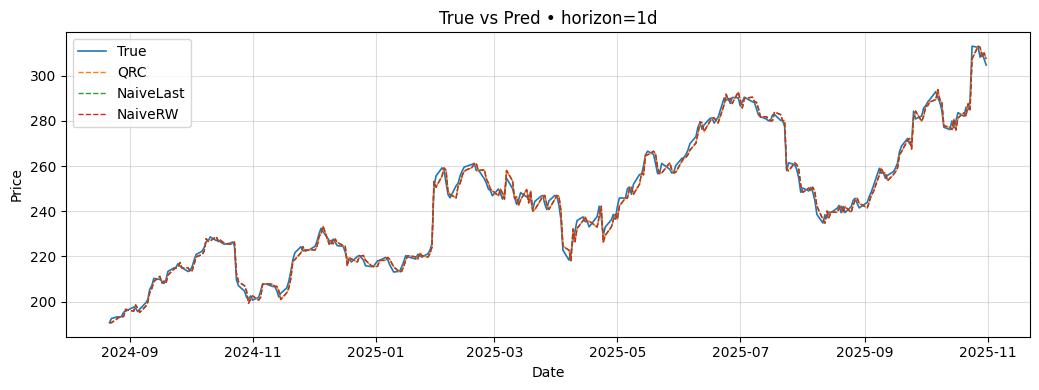

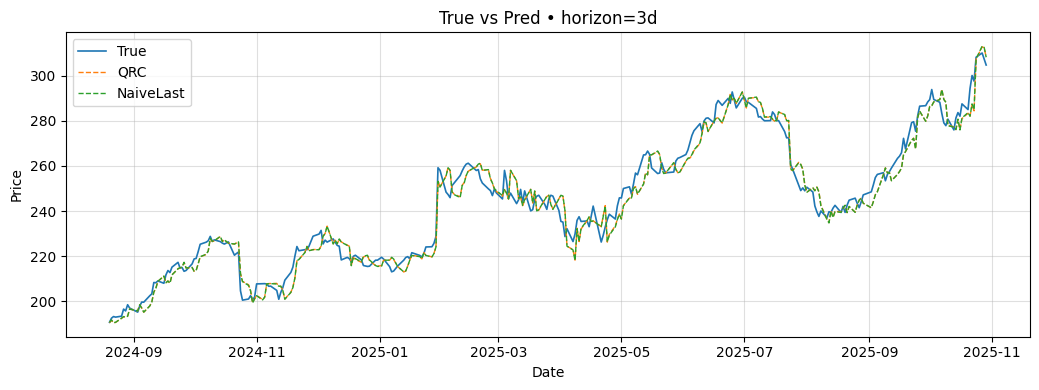

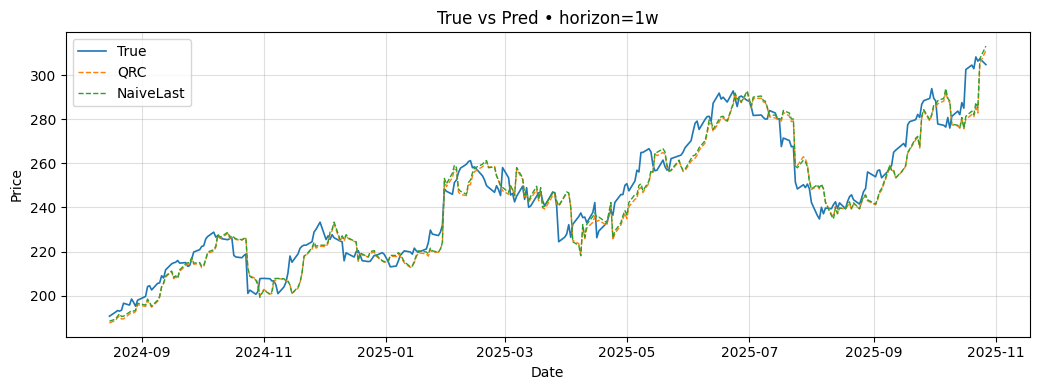

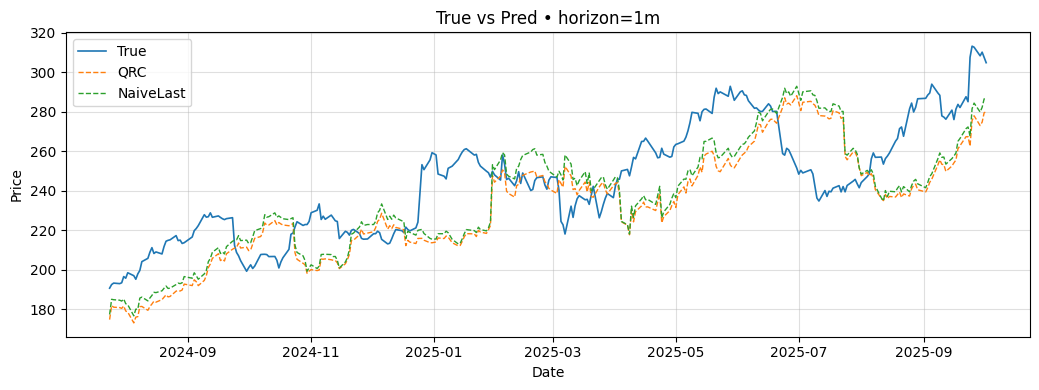

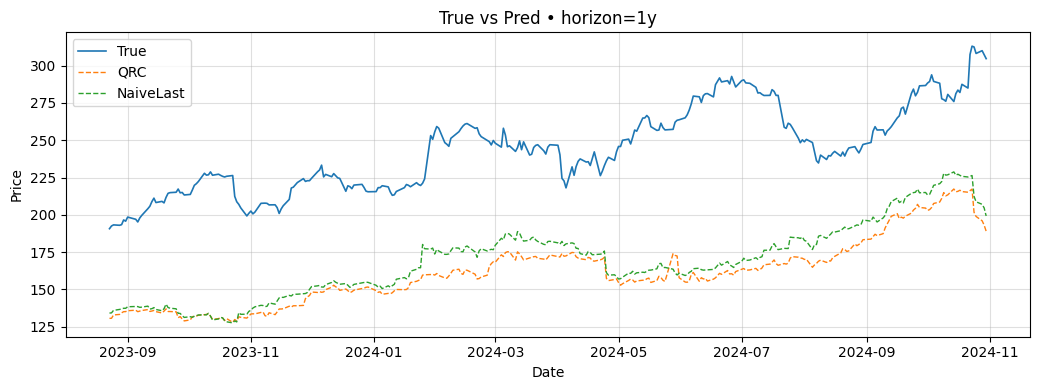

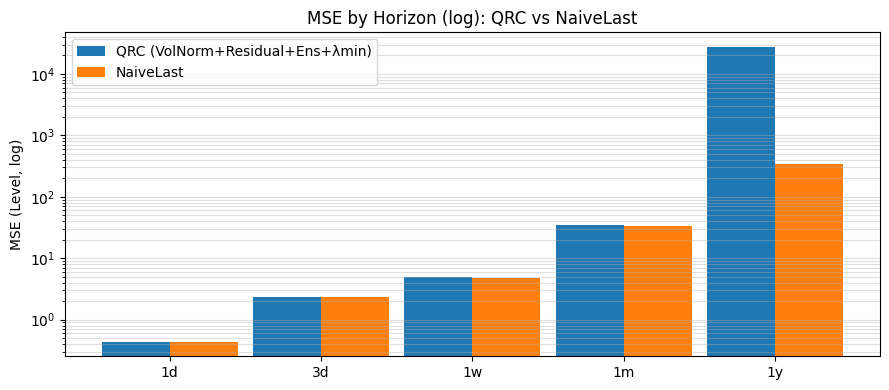

In [43]:
# === 3) 結果表示（NaiveRWは1dのみ、棒は対数スケール） =========================
# 折れ線：1dは NaiveRW も表示、3d以上は表示しない
for name,_ in HORIZONS:
    lf = results[name]["last_fold_plot"]
    if name == "1d":
        curves = {"QRC": lf["qrc"], "NaiveLast": lf["naive"], "NaiveRW": lf["rw"]}
    else:
        curves = {"QRC": lf["qrc"], "NaiveLast": lf["naive"]}
    plot_overlay_price(lf["dates"], lf["true"], curves, title=f"True vs Pred • horizon={name}", last_n=300)

# 棒：MSE（対数スケール）— QRC vs NaiveLast
plot_mse_bars_qrc_vs_naive_log(mse_rows)
